In [1]:
import numpy as np
import time
from scipy import misc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import json

$\inf_{u}\mathbb{E}\left[\int_0^T \left(ax_t^2+bx_t+Au_t^2+Bu_t\right)dt + \alpha x_T^2+\beta x_T\right]$

$dx_t = (cx_t+du_t)dt+\sigma dB_t$

$0=\partial_t V(t,x)+\frac{\sigma^2}{2}\partial_x^2V(t,x) +cx\partial_xV(t,x)+ax^2+bx+\inf_u\Big[Au^2+\Big(B+d\partial_xV(t,x)\Big)u\Big]$

$V(T,x)=\alpha x^2+\beta x$


$u^*=-\frac{B+d\partial_xV(t,x)}{2A}$

$0=\partial_t V(t,x)+\frac{\sigma^2}{2}\partial_x^2V(t,x) +cx\partial_xV(t,x)+ax^2+bx-\frac{\big(B+d\partial_xV(t,x)\big)^2}{4A}$

$V(t,x)=f(t)x^2+h(t)x+k(t)$


$0=f'+a+2cf-\frac{d^2}{A}f^2;  f(T)=\alpha$

$0=h'+b-\frac{(B+dh)d}{A}f;  h(T)=\beta$

$0=k'+\sigma^2 f-\frac{1}{4A}(B+dh)^2;  k(T)=0$

$f'=q_0+q_1f+q_2f^2;  f(0)=\alpha$, 

$q_0=1$, $q_1=2c$, and $q_2 = -\frac{d^2}{A}$.


$S = q_0q_2$ and $R=q_1$

$F' = S+R F + F^2$, $F(0)=q_2\alpha$

$F=-\dfrac{K'}{K}$

$K^{\prime\prime} - R K^{\prime} + S K= 0$

$K(t) = c_1 \sinh \lambda_1 t + c_2\cosh\lambda_2 t$

$\lambda_{1/2} = \dfrac{R+\sqrt{R^2-4S}}{2}$

$F=-\dfrac{K'}{K}=-\dfrac{c_1 \lambda_1\cosh \lambda_1 t + c_2\lambda_2\sinh\lambda_2 t}{c_1 \sinh \lambda_1 t + c_2\cosh\lambda_2 t}$

$F(0) =-\dfrac{c_1 \lambda_1}{c_2} =q_2\alpha$. Therefore, $c_1 = -\dfrac{c_2q_2\alpha}{\lambda_1}$


$F=-\dfrac{K'}{K}=-\dfrac{-\dfrac{q_2\alpha}{\lambda_1} \lambda_1\cosh \lambda_1 t + \lambda_2\sinh\lambda_2 t}{-\dfrac{q_2\alpha}{\lambda_1} \sinh \lambda_1 t + \cosh\lambda_2 t}$


$f(t)=\dfrac{A}{d^2}\dfrac{-\dfrac{q_2\alpha}{\lambda_1} \lambda_1\cosh \lambda_1 t + \lambda_2\sinh\lambda_2 t}{-\dfrac{q_2\alpha}{\lambda_1} \sinh \lambda_1 t + \cosh\lambda_2 t}$

$h(t) = \dfrac{\beta+\frac{\beta}{d}+\frac{q_2\alpha b}{\lambda_1^2}}{-\dfrac{q_2\alpha}{\lambda_1} \sinh \lambda_1 t + \cosh\lambda_2 t}+\dfrac{-\dfrac{q_2\alpha b}{\lambda_1^2} \cosh \lambda_1 t + \dfrac{b}{\lambda_2}\sinh\lambda_2 t}{-\dfrac{q_2\alpha}{\lambda_1} \sinh \lambda_1 t + \cosh\lambda_2 t}-\dfrac{B}{d}$

$k(t)$= Need to solve numerical inrtegration as we have to take h square

$u^*=-\frac{B+d(2xf(t)+h(t))}{2A}$

In [2]:
M=100
ite=10
block=[9]
#block=[0,1,2,3,4,5,6,7,8,9]
T=1
T_c=1
T_f=0.1
delta_c=torch.tensor(T_c/ite)
delta_f=torch.tensor(T_f/ite)
a=0.1
b=0.1
c=0.1
d=0.1
A=0.1
B=0.1
sigma=0.01
alpa=0.1
beta=0.1
neuron_model_psi=10
neuron_model_value=10
dim_n=2
up_lim=1
print(delta_c,delta_f)

tensor(0.1000) tensor(0.0100)


In [3]:
model_f= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [4]:
# model_value= torch.nn.Sequential(
#     torch.nn.Linear(dim_n, neuron_model_value),
#     torch.nn.Tanh(),
# #     torch.nn.BatchNorm1d(neuron_model_value),
# #     torch.nn.Linear(neuron_model_value, neuron_model_value),
# #     torch.nn.Tanh(),
# #     torch.nn.Linear(neuron_model_value, neuron_model_value),
# #     torch.nn.ReLU(),
# #     torch.nn.Linear(neuron_model_value, neuron_model_value),
# #     torch.nn.Tanh(),
# #     torch.nn.Linear(neuron_model_value, neuron_model_value),
# #     torch.nn.Tanh(),
#     torch.nn.Linear(neuron_model_value,1)
# )

In [5]:
model_coarse = torch.load('model_N10_LQC_uniform_0_1_alpa_0.1.pth')
model_value=torch.load('model_N10_LQC_Value_uniform_0_1_alpa_0.1.pth')

In [6]:
data=np.load('state_var_dic_N10_uniform_0_1.npz')
state_data = torch.tensor(data['state variable'])
sample=state_data[0]
print(state_data.shape)

torch.Size([11, 100, 2])


In [7]:
def update(x3,psi,z,i,delta):
    t=(x3[:,0]+(T_f/ite))
    #print(x3[:,1].shape,z[:,i].shape,psi.shape)
    x=x3[:,1]+(c*x3[:,1]+d*psi)*delta+sigma*torch.sqrt(delta)*z[:,i]
    up=torch.cat((t.unsqueeze(1),x.unsqueeze(1)),dim=1)
#     print('up shape=', up.shape)
    return up
    
def loss_func(x2,psi):
    loss=a*torch.pow(x2[:,1],2)+b*x2[:,1]+A*torch.pow(psi,2)+B*psi
    return loss

# def loss_func_ter(x4,f,h,k,i):
#     v_f=f[i+1]*torch.pow(x4[:,1],2)+h[i+1]*x4[:,1]+k[i+1]
#     return v_f

def unit(x1,model,i,delta):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi,z,i,delta)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(model,model_V,data,delta):
    loss_total=0.0    
    for num in range(len(block)):       
        loss=torch.zeros(M,ite)
        psi=torch.zeros(M,ite)
        block_pos=block[num]
        t=torch.zeros([M,1])+block_pos*delta_c
        element=data[block_pos,:,1].reshape(M,1)
        u=torch.cat((t,element),dim=1)
        for i in range(ite+1):
            if(i<ite):
                psi_run,loss_run,u_run=unit(u,model,i,delta)
                #print('los func=',psi_run.shape,loss_run.shape)
                loss[:,i]=loss_run
                #print(loss)
                psi[:,i]=psi_run
                #print(psi)
                u=u_run
              #print(u)
            else:
#                 loss_ter=loss_func_ter(u,f,h,k,block_pos)
                loss_ter=model_V(u).squeeze(1).clone().detach()  
                #print('ter',torch.mean(loss_ter))
        #print(torch.mean(torch.sum(loss,dim=1)))
        loss_block=torch.sum(loss,dim=1)*delta+loss_ter
        loss_total=loss_total+loss_block
    return torch.mean(loss_total)

In [8]:
def get_data(model,x):
    cost=torch.zeros(M,ite)
    cost_sum = torch.zeros(M,ite)
    psi=torch.zeros(M,ite)
    for i in range(ite):
        psi[:,i]=model(x[i,:,]).squeeze(1).clone().detach()  
        if(i<ite-1):
            cost[:,i]=loss_func(x[i,:,],psi[:,i])
        else:
            cost[:,i]=alpa*torch.pow(x[i,:,][:,1],2)+beta*x[i,:,][:,1]
    for col in range(ite):
        cost_sum[:, col] = torch.sum(cost[:, col:], axis=1)
    return torch.t(cost),torch.t(cost_sum),torch.t(psi)       
    

In [9]:
# def test_cost(model,x):
#     cost=0.0
#     psi=torch.zeros(M,ite)
    
#     for i in range(ite):
#         psi[:,i]=model(x[i,:,]).squeeze(1).clone().detach()  
#         if(i<ite-1):
#             cost=cost+loss_func(x[i,:,],psi[:,i])
#         else:
#             cost=cost+alpa*torch.pow(x[i,:,][:,1],2)+beta*x[i,:,][:,1]
#     return cost
    

In [10]:
# cost,cost_sum,u=get_data(model_coarse,state_data_deleted)
# print(cost.shape,cost_sum.shape,u.shape)
# print(cost[1]-(cost_sum[1]-cost_sum[2]))

In [11]:
# x_train = state_data_deleted.view(-1, 2)
# print(x_train.shape)
# y_train = cost[9,]
# print(y_train)

In [12]:
# x_train_np = x_train.numpy()
# y_train_np = y_train.numpy().ravel()  # Flatten y_train_np to 1D

# # Create a figure for the plot
# plt.figure(figsize=(6, 6))

# # Scatter plot of true y_train values against x_train[:, 1]
# plt.scatter(x_train_np[-1000:,1], y_train_np[-1000:,], color='b', label='True y_train values')

# # # Fit a quadratic curve to visualize the relationship
# # coeffs = np.polyfit(x_train_np[:, 1], y_train_np, 2)  # Fit a 2nd degree polynomial (quadratic)
# # poly = np.poly1d(coeffs)  # Create a polynomial function from the coefficients

# # # Generate x values for the fitted curve
# # x_vals = np.linspace(min(x_train_np[:, 1]), max(x_train_np[:, 1]), 100)
# # y_vals = poly(x_vals)  # Compute the fitted y values

# # # Plot the fitted quadratic curve
# # plt.plot(x_vals, y_vals, color='r', label='Fitted Quadratic Curve')

# # Add labels, title, and legend
# plt.title('x_train[:, 1] vs y_train')
# plt.xlabel('x_train (2nd column)')
# plt.ylabel('y_train')
# plt.legend()

# # Show the plot
# plt.show()

# Generating data

In [13]:
state_data_deleted=state_data[1:, :, :] # deleting the element time zero samples
cost,cost_sum,psi = get_data(model_coarse,state_data_deleted)
psi = psi.unsqueeze(2)
z=torch.FloatTensor(M,ite+1).uniform_(0,0.01)
#x_train = torch.cat((state_data, psi), dim=2)
#x_train = state_data_deleted.view(-1, 2)
x_train = state_data_deleted.reshape(M*ite,2)
y_train = cost_sum.reshape(M*ite, 1)
#print(x_train[-100:],y_train[-100:])
print(state_data_deleted[0,:,1])

print(torch.min(x_train),torch.max(x_train))
print(torch.min(y_train),torch.max(y_train))

tensor([ 0.9448,  0.0094,  0.0338,  0.6581,  0.5861,  0.1791,  0.3740,  0.3540,
         0.1440,  0.8449,  0.7149,  0.0739,  0.0024,  0.8693,  0.5229,  0.3389,
         0.5217,  0.6601,  0.1513,  0.2405,  0.8266,  0.4307,  1.0002,  0.8662,
         0.1454,  0.5307,  0.3599,  0.1900,  0.6662,  0.6674,  0.4938,  0.6953,
         0.5993, -0.0036,  0.2202,  0.9512,  0.6106,  0.6844,  0.4473,  0.1247,
         0.8425,  0.0082,  0.1199,  0.0353,  0.6310,  0.7769,  0.9575,  0.1694,
         0.3363,  0.8912,  0.3941,  0.2471,  0.0061,  0.2441,  0.6460,  0.5565,
         0.3440,  0.1714,  0.3599,  0.0473,  0.8315,  0.9228,  0.4132,  0.6474,
         0.7933,  0.6667,  0.3326,  0.2581,  0.5280,  0.8908,  0.2402,  0.7484,
         0.9386,  0.4777,  0.7194,  0.4445,  0.0674,  0.6754,  0.5898,  0.9798,
         0.5804,  0.0848,  0.7997,  0.7048,  0.4994,  0.4523,  0.6485,  0.0670,
         0.4143,  0.0191,  0.6312,  0.8732,  0.2478,  0.5421,  0.9587,  0.7545,
         0.4071,  0.8669,  0.6834,  0.25

In [14]:
# start=time.time()
# lr1 = 8e-3
# max_epoch = 1000
# cost_ar=[]
# optimizer = optim.Adam(model_f.parameters(), lr1)

# #print(psi.shape)
# for epoch in range(max_epoch):
#   optimizer.zero_grad()
#   cost=loss_func_total(model_f,model_value,state_data_deleted,delta_f)
#   cost.backward()
#   optimizer.step()
#   cost_ar.append(cost)
#   #print(loss.item())
#   if (epoch % 100==0):
#     print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
# end=time.time()
# total_time=end-start
# print('time elapsed=',total_time)

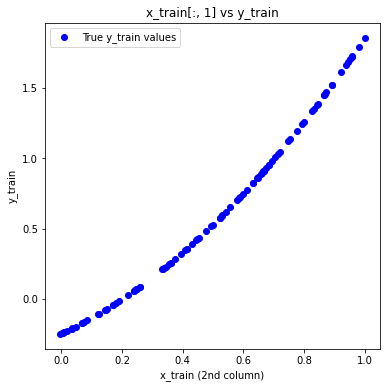

In [15]:
# Assuming x_train and y_train are PyTorch tensors; convert them to NumPy arrays
x_train_np = x_train.numpy()
y_train_np = y_train.numpy() # Flatten y_train_np to 1D

# Create a figure for the plot
plt.figure(figsize=(6, 6))

# Scatter plot of true y_train values against x_train[:, 1]
# plt.scatter(x_train_np[-1000:,1], y_train_np[-1000:,], color='b', label='True y_train values')
plt.scatter(x_train_np[:M,1], y_train_np[:M,], color='b', label='True y_train values')

# # Fit a quadratic curve to visualize the relationship
# coeffs = np.polyfit(x_train_np[:, 1], y_train_np, 2)  # Fit a 2nd degree polynomial (quadratic)
# poly = np.poly1d(coeffs)  # Create a polynomial function from the coefficients

# # Generate x values for the fitted curve
# x_vals = np.linspace(min(x_train_np[:, 1]), max(x_train_np[:, 1]), 100)
# y_vals = poly(x_vals)  # Compute the fitted y values

# # Plot the fitted quadratic curve
# plt.plot(x_vals, y_vals, color='r', label='Fitted Quadratic Curve')

# Add labels, title, and legend
plt.title('x_train[:, 1] vs y_train')
plt.xlabel('x_train (2nd column)')
plt.ylabel('y_train')
plt.legend()

# Show the plot
plt.show()

# Visualizing data

Box plot of X_train and y_train

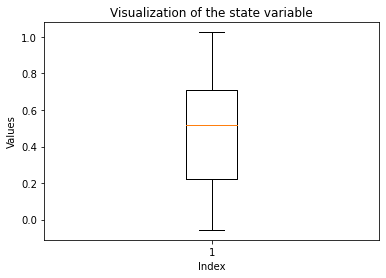

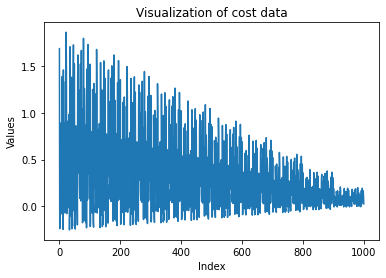

In [16]:
x_train_np=x_train.numpy()
y_train_np=y_train.numpy()

plt.figure(figsize=(6, 4))

plt.boxplot(x_train_np[:,1],vert=True)
plt.title('Visualization of the state variable')
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(y_train)
plt.title('Visualization of cost data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()

Histogram of X_train and y_train

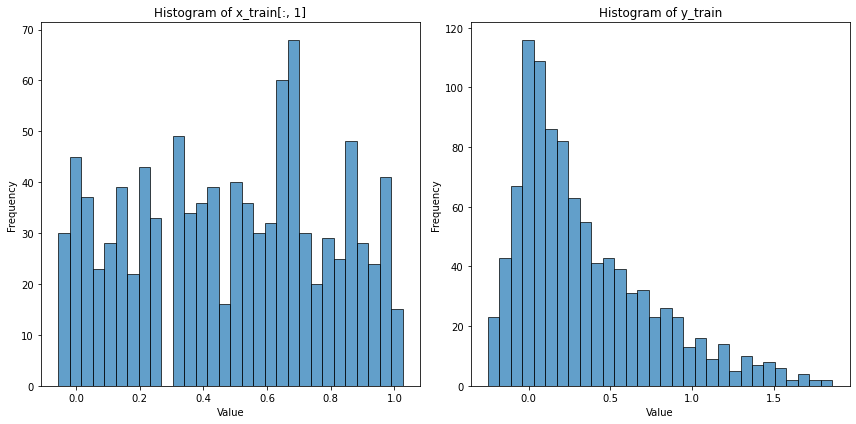

In [17]:

# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for the second column of x_train
axs[0].hist(x_train_np[:, 1], bins=30, edgecolor='black', alpha=0.7)
axs[0].set_title('Histogram of x_train[:, 1]')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Histogram for y_train
axs[1].hist(y_train_np, bins=30, edgecolor='black', alpha=0.7)
axs[1].set_title('Histogram of y_train')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


We are interested to see if the value function is a quadratic function of teh state variable. The following graph does not indicates such relationship.

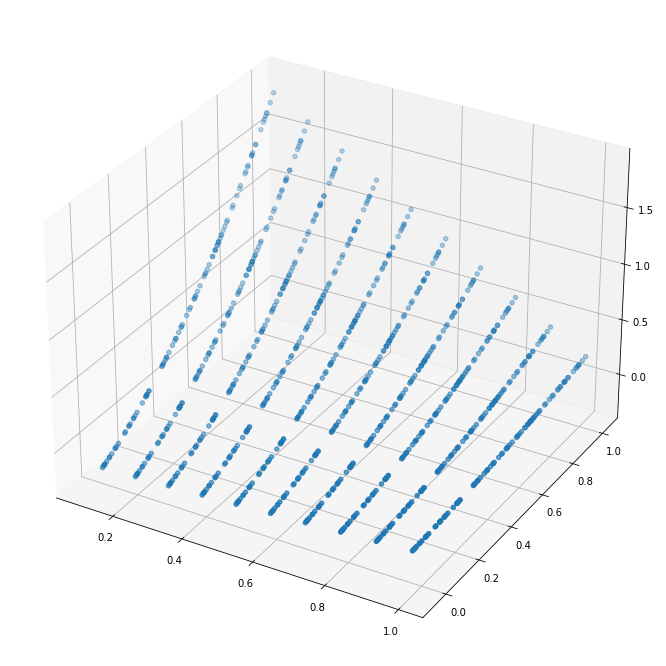

In [18]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_train_np[:,0], x_train_np[:,1], y_train_np)
plt.show()

In [19]:
import plotly.graph_objects as go

# Assuming x_train_np and y_train_np are your numpy arrays
# x_train_np[:, 0] -> X data
# x_train_np[:, 1] -> Y data
# y_train_np -> Z data

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x_train_np[:, 0],  # X-axis data
    y=x_train_np[:, 1],  # Y-axis data
    z=y_train_np[:, 0],  # Z-axis data (adjust as needed for shape)
    mode='markers',      # Marker style
    marker=dict(
        size=5,          # Size of markers
        color=y_train_np[:, 0],  # Color by Z-axis values
        colorscale='Viridis',  # Color scale
        opacity=0.8      # Opacity of the markers
    )
)])

# Update the layout for labels and title
fig.update_layout(
    title="Interactive 3D Scatter Plot On Training Sample",
    scene=dict(
        xaxis_title="Time",
        yaxis_title="State Variable x",
        zaxis_title="Value function"
    ),
    margin=dict(l=0, r=0, b=0, t=40)  # Tight layout
)

# Show the interactive plot
fig.show()



# Training Value network

In [20]:
# num_epochs = 8000
# criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
# optimizer = optim.Adam(model_value.parameters(), lr=0.01)
# for epoch in range(num_epochs):
#     model_value.train()
    
#     # Forward pass
#     outputs = model_value(x_train)
#     loss = criterion(outputs, y_train)
    
#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     if (epoch+1) % 1000 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

# Closed form continuous solution

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


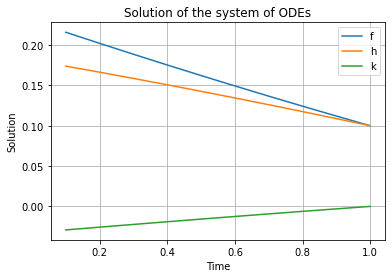

In [21]:
# Define the system of ODEs
def system_of_odes(t, y):
    dydt = [
        a+2*c*y[0]-(d**2*y[0]**2)/A,                 # df/dt = a+2cf-d^2*f^2/A; f(0)=alpa
        b-(B+d*y[1])*d*y[0]/A,                       # dh/dt = b-(B+dh)fd/A; h(0)=beta
        sigma**2*y[0]-(B+d*y[1])**2/(4*A)        # dk/dt = sigma^2*f-(B+dh)^2/4A; k(0)=0
    ]
    return dydt

# Initial conditions
initial_conditions = [alpa, beta, 0]  # Initial values for y1, y2, and y3

# Time span
t_span = (0.1, T_c)  # Start and end time
t_eval=np.linspace(0.1, 1, ite)
print(t_eval)
# Solve the system of ODEs
sol = solve_ivp(system_of_odes,t_span, initial_conditions, t_eval=np.linspace(0.1, 1, ite))

f=np.flip(sol.y[0])
h=np.flip(sol.y[1])
k=np.flip(sol.y[2])
# Plot the solution
plt.plot(sol.t, f, label='f')
plt.plot(sol.t, h, label='h')
plt.plot(sol.t, k, label='k')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution of the system of ODEs')

plt.legend()
plt.grid(True)
plt.show()

# Testing the value function

In [22]:
def optimal_soln_numerical(x,f,h):
    u=-(B+d*(2*x*f+h))/(2*A)
    return u

def value_func_numerical(x,f,h,k):
    V=f*x**2+h*x+k
    return V 

In [23]:
def value_func_testing(x,M2,ite,model_c,model_v):
    
    v_pred=torch.zeros(M2,ite)
    v_closed=np.zeros((M2,ite))
    cost_test=torch.zeros(M2,ite)
    v_dis = torch.zeros(M2,ite)
    psi=torch.zeros(M2,ite)

    for i in range (ite):
        time_step=(i+1)*0.1  # we want to test from time 0.1 to 1
        t = (torch.ones(M2) * time_step).unsqueeze(1)
        x_v_test=torch.cat((t,x),dim=1)
        v_pred[:,i] = model_v(x_v_test).squeeze(1).clone().detach()         
        v_closed[:,i]=value_func_numerical(x.numpy(),f[i],h[i],k[i]).reshape(M2)

        psi[:,i]=model_c(x_v_test).squeeze(1).clone().detach()  
        if(i<ite-1):
            cost_test[:,i]=loss_func(x_v_test,psi[:,i])
        else:
            cost_test[:,i]=alpa*torch.pow(x_v_test[:,1],2)+beta*x_v_test[:,1]

    for col in range(ite):
        v_dis[:, col] = torch.sum(cost_test[:, col:], axis=1)
    return v_pred,v_closed,v_dis

In [24]:
def plot_value_function(x,M2,v_pred,v_closed,v_dis):
    for i in range (ite):        
        print('Absolute Difference with the continuous value and predicetd value \n',np.abs((v_pred[:,i]-v_closed[:,i]).numpy()))
        print('Absolute Difference with the discrete value and predicetd value \n',np.abs((v_pred[:,i]-v_dis[:,i]).numpy()))
        plt.figure()  # Create a new figure for each plot
        plt.plot(x, v_pred[:,i], color='b', label='Value_Predicted')
        plt.plot(x,v_closed[:,i], color='r', label='Value_Closed_Continuous')
        plt.plot(x,v_dis[:,i], color='g', label='Value_Discrete')
        plt.xlabel('State Variable')
        plt.ylabel('Value Function')
        plt.title(f'Predicted Value function at time step = {0.1*(i+1):.1f}')
        plt.legend()

        # Show each plot separately
        plt.show()
    return 

Absolute Difference with the continuous value and predicetd value 
 [0.12469677 0.00378575 0.15290269 0.32375719 0.51749775 0.73594573
 0.98031873 1.24655217]
Absolute Difference with the discrete value and predicetd value 
 [0.02594128 0.02353774 0.02130248 0.01785871 0.01181692 0.00229084
 0.01103449 0.02431393]


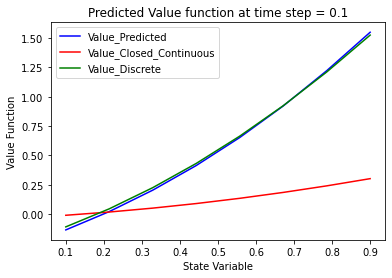

Absolute Difference with the continuous value and predicetd value 
 [0.10875481 0.0044971  0.13647488 0.28812657 0.45988452 0.65262705
 0.86789897 1.10546705]
Absolute Difference with the discrete value and predicetd value 
 [0.02030437 0.01891231 0.01723593 0.01405355 0.00882739 0.00129604
 0.00909317 0.02208173]


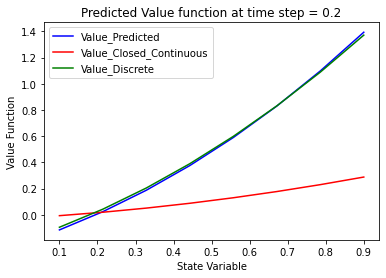

Absolute Difference with the continuous value and predicetd value 
 [0.09355358 0.00462188 0.11950698 0.25211643 0.4024847  0.57050774
 0.7569378  0.96291593]
Absolute Difference with the discrete value and predicetd value 
 [1.55845955e-02 1.50877386e-02 1.39559507e-02 1.09009445e-02
 6.13695383e-03 7.52806664e-05 7.72750378e-03 1.74856186e-02]


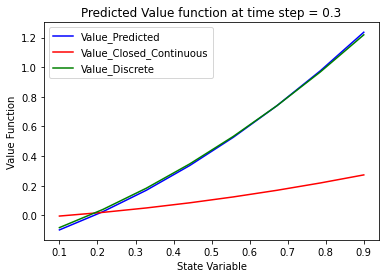

Absolute Difference with the continuous value and predicetd value 
 [0.0788852  0.00439287 0.1021745  0.21565547 0.34478809 0.48877938
 0.6472581  0.82110995]
Absolute Difference with the discrete value and predicetd value 
 [0.0115682  0.01182488 0.01128021 0.00862572 0.00422794 0.00112015
 0.0068081  0.01279497]


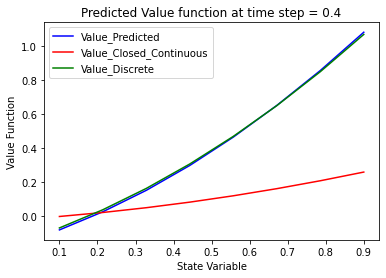

Absolute Difference with the continuous value and predicetd value 
 [0.06440432 0.00422662 0.0849424  0.17912818 0.28687407 0.40709192
 0.53847887 0.68095024]
Absolute Difference with the discrete value and predicetd value 
 [0.00790395 0.00870078 0.00875103 0.00684988 0.00299317 0.0017311
 0.00602001 0.00896925]


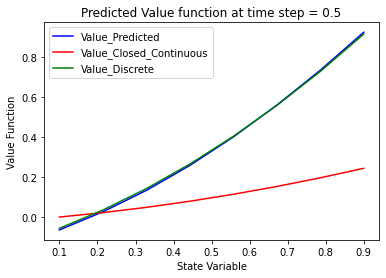

Absolute Difference with the continuous value and predicetd value 
 [0.04996713 0.00435534 0.06815682 0.14293858 0.22902777 0.32538974
 0.43023378 0.5425097 ]
Absolute Difference with the discrete value and predicetd value 
 [0.00444203 0.00547678 0.00615218 0.00514214 0.00211963 0.00188082
 0.00506854 0.00610697]


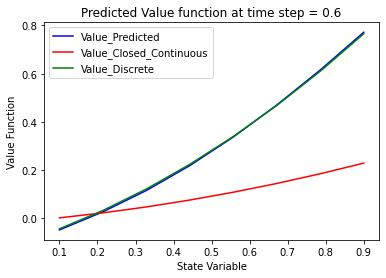

Absolute Difference with the continuous value and predicetd value 
 [0.03576028 0.00467235 0.05184172 0.10725041 0.17145824 0.24372342
 0.32226132 0.40549688]
Absolute Difference with the discrete value and predicetd value 
 [0.0013631  0.0022944  0.00343268 0.00331123 0.00137031 0.00164834
 0.0039601  0.00396442]


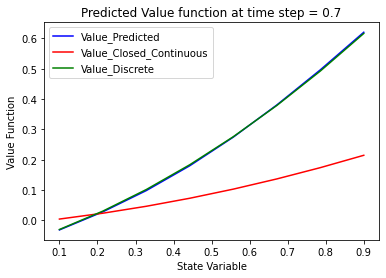

Absolute Difference with the continuous value and predicetd value 
 [0.02227715 0.00473073 0.0356604  0.07188761 0.11413916 0.16209327
 0.2143997  0.26957954]
Absolute Difference with the discrete value and predicetd value 
 [0.00084552 0.00034007 0.0009023  0.00150585 0.00074381 0.0010621
 0.0025616  0.00227579]


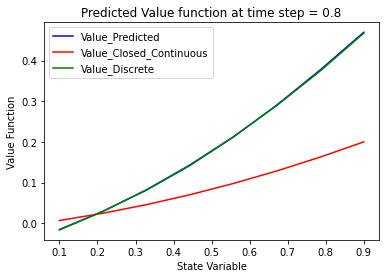

Absolute Difference with the continuous value and predicetd value 
 [0.01022332 0.0038301  0.01897425 0.03635099 0.05676485 0.0803621
 0.10654734 0.13455856]
Absolute Difference with the discrete value and predicetd value 
 [1.4368957e-03 1.7528366e-03 8.2734972e-04 1.9773096e-04 5.1787496e-04
 1.3202429e-05 8.0013275e-04 1.0808408e-03]


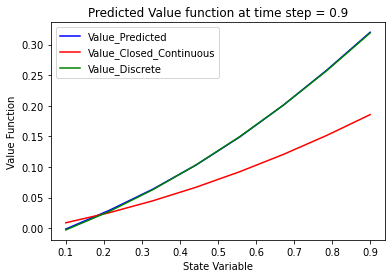

Absolute Difference with the continuous value and predicetd value 
 [0.00040877 0.00112244 0.00094572 0.00010433 0.00121598 0.00176389
 0.00136891 0.00043713]
Absolute Difference with the discrete value and predicetd value 
 [0.00040877 0.00112244 0.00094572 0.00010433 0.00121598 0.00176389
 0.00136891 0.00043713]


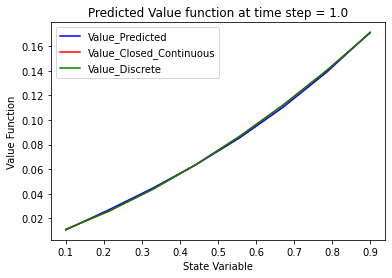

In [25]:
M2=8
x=torch.linspace(0.1*up_lim,0.9*up_lim, steps=M2).unsqueeze(1)

value_pred,value_closed,value_discrete=value_func_testing(x,M2,ite,model_coarse,model_value)
plotting=plot_value_function(x,M2,value_pred,value_closed,value_discrete)

In [26]:
# v=np.zeros(M2)  # checking if v_func works correct
# for i in range(M2):
#     v[i]=f[0]*x[i]**2+h[0]*x[i]+k[0]
# print(v)
# print(v_closed[:,0])

In [27]:
# torch.save(model_value, 'model_N10_LQC_Value_uniform_0_1.pth')

# Training control network

In [28]:
start=time.time()
lr1 = 8e-3
max_epoch = 1000
cost_ar=[]
optimizer = optim.Adam(model_f.parameters(), lr1)

#print(psi.shape)
for epoch in range(max_epoch):
  optimizer.zero_grad()
  cost=loss_func_total(model_f,model_value,state_data_deleted,delta_f)
  cost.backward()
  optimizer.step()
  cost_ar.append(cost)
  #print(loss.item())
  if (epoch % 100==0):
    print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
end=time.time()
total_time=end-start
print('time elapsed=',total_time)

At epoch 0 the mean cost is 0.09873626381158829.
At epoch 100 the mean cost is 0.08561389148235321.
At epoch 200 the mean cost is 0.08561639487743378.
At epoch 300 the mean cost is 0.08561743795871735.
At epoch 400 the mean cost is 0.08561757206916809.
At epoch 500 the mean cost is 0.08561770617961884.
At epoch 600 the mean cost is 0.08561781793832779.
At epoch 700 the mean cost is 0.08561797440052032.
At epoch 800 the mean cost is 0.08561810851097107.
At epoch 900 the mean cost is 0.08561816066503525.
time elapsed= 4.540008544921875


In [29]:
M2=10
x_ar=[]
z1=torch.FloatTensor(M2,ite+1).uniform_(0,0.01)
t_test=torch.zeros([M2,1])
x1=torch.linspace(0.1*up_lim,0.95*up_lim, steps=M2).unsqueeze(1)
x_test=torch.cat((t_test,x1),dim=1)
#pred_soln=torch.zeros(M2,ite)
pred_soln=[]
for i in range(ite):
    for j in range(ite):        
        x_ar.append(x_test[:,1].numpy())
        soln_pred=model_f(x_test).squeeze(1).detach()
        #print(soln_pred)
        #pred_soln[:,i]=soln_pred
        pred_soln.append(soln_pred.numpy())
        x_test=update(x_test,soln_pred,z1,j,delta_f)
#         if(torch.floor(x_test[0,0]*10)!=0):
#             x_test[:,0]=0.0
#         print(x_test)
x_ar.append(x_test[:,1].numpy())
state_var=np.squeeze(np.array(x_ar))
state_var=state_var.transpose()
pred=np.squeeze(np.array(pred_soln))
pred=pred.transpose()
print(pred.shape,state_var.shape)
# print(pred[0],state_var[0])

(10, 100) (10, 101)


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


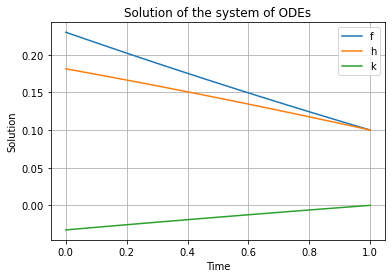

In [30]:
# Define the system of ODEs
def system_of_odes(t, y):
    dydt = [
        a+2*c*y[0]-(d**2*y[0]**2)/A,                 # df/dt = a+2cf-d^2*f^2/A; f(0)=alpa
        b-(B+d*y[1])*d*y[0]/A,                       # dh/dt = b-(B+dh)fd/A; h(0)=beta
        sigma**2*y[0]-(B+d*y[1])**2/(4*A)        # dk/dt = sigma^2*f-(B+dh)^2/4A; k(0)=0
    ]
    return dydt

# Initial conditions
initial_conditions = [alpa, beta, 0]  # Initial values for y1, y2, and y3

# Time span
t_span = (0, T_c)  # Start and end time
t_eval=np.linspace(0, T_c, ite*ite+1)
print(t_eval)
# Solve the system of ODEs
sol = solve_ivp(system_of_odes,t_span, initial_conditions, t_eval=np.linspace(0, T_c, ite*ite+1))

f=np.flip(sol.y[0])
h=np.flip(sol.y[1])
k=np.flip(sol.y[2])
# Plot the solution
plt.plot(sol.t, f, label='f')
plt.plot(sol.t, h, label='h')
plt.plot(sol.t, k, label='k')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution of the system of ODEs')

plt.legend()
plt.grid(True)
plt.show()

In [31]:
def total_cost(x,u,ite):
    cost_run=0.0
    for i in range(ite+1):
        if(i<ite):
            cost_run=cost_run+a*x[i]**2+b*x[i]+A*u[i]**2+B*u[i]
        else:
            cost_ter=alpa*x[i]**2+beta*x[i]
    cost_total=cost_run*delta_f.numpy()+cost_ter 
    return cost_total

In [32]:
def optimal_soln_closed(x,t):
    q0=1
    q1=2*c
    q2=-d**2/A
    S=q0*q2
    R=q1
    L1=(R+np.sqrt(R**2-4*S))/2
    L2=(R-np.sqrt(R**2-4*S))/2
    
    top = (-q2*alpa*np.cosh(L1*t)+L2*np.sinh(L2*t))
    bottom = ((-q2*alpa/L1)*np.sinh(L1*t)+np.cosh(L2*t))
    
    f = (A/d**2)*top/bottom
    h = ((-q2*alpa*b/L1**2)*np.cosh(L1*t)+b*np.sinh(L2*t)/L2)/bottom - B/d +(beta+B/d+q2*alpa*b/L1**2)/bottom
#     k = sigma**2*np.log(bottom)   
    u = -(B+d*(2*x*f+h))/(2*A)
    
    return u

In [33]:
u=np.zeros([M2,ite*ite+1])
u1=np.zeros([M2,ite*ite+1])
V=np.zeros([M2,ite*ite+1])
t_eval=np.linspace(0, T_c, ite*ite+1)
pred_cost=np.zeros(M2)
numeric_cost=np.zeros(M2)
error_percnt=np.zeros(M2)
# pred=pred_soln.numpy()
# print(state_var[0,:].shape,u[0,:].shape,ite)
print(pred[0,:].shape,u[0,:].shape)
for i in range(M2):
    #print('state variable',state_var[i].shape,u[i,:].shape,optimal_soln(state_var[i],f,h).shape,pred[i,:].shape)
#     u[i,:]=optimal_soln_closed(state_var[i,:],t_eval)
    u1[i,:]=optimal_soln_numerical(state_var[i,:],f,h)
    print('\n Numerical solution',u1[i,:])
    numeric_cost[i]=total_cost(state_var[i,:],u1[i,:],ite)
    print('\n Numerical cost=',numeric_cost[i])
    print('\n Predicted solution',pred[i])
    pred_cost[i]=total_cost(state_var[i,:],pred[i],ite)
    print('\n Predicted cost=',pred_cost[i])
    error_percnt[i]= np.abs(100*(np.abs(numeric_cost[i])-np.abs(pred_cost[i]))/numeric_cost[i])
    print('Percent Error wrt Numeric Cost=',error_percnt[i],'%\n')
    

(100,) (101,)

 Numerical solution [-0.61362501 -0.61306082 -0.61249594 -0.61193182 -0.61136677 -0.61080036
 -0.61023387 -0.60966803 -0.60910093 -0.60853382 -0.6079671  -0.60740022
 -0.60683273 -0.606266   -0.60569844 -0.60512965 -0.60456082 -0.60399266
 -0.60342335 -0.60285408 -0.60228523 -0.60171626 -0.60114678 -0.60057804
 -0.60000858 -0.59943801 -0.59886746 -0.59829757 -0.59772667 -0.59715584
 -0.59658545 -0.596015   -0.59544412 -0.59487392 -0.59430302 -0.59373106
 -0.59315907 -0.59258769 -0.59201532 -0.59144301 -0.59087108 -0.59029908
 -0.58972665 -0.5891549  -0.58858255 -0.58800928 -0.58743605 -0.58686344
 -0.58628998 -0.58571664 -0.58514371 -0.58457078 -0.58399753 -0.58342496
 -0.5828519  -0.58227805 -0.58170432 -0.58113122 -0.5805574  -0.57998376
 -0.57941057 -0.57883744 -0.57826408 -0.57769142 -0.57711838 -0.57654468
 -0.57597115 -0.57539828 -0.57482482 -0.57425159 -0.57367884 -0.57310623
 -0.57253347 -0.57196143 -0.57138911 -0.57081626 -0.57024365 -0.5696717
 -0.5690993  -0.5

 -0.50603086 -0.5076635  -0.5092961  -0.5109287 ]

 Predicted cost= 0.05599563988284139
Percent Error wrt Numeric Cost= 0.2833550702918136 %


 Numerical solution [-0.70044568 -0.69943325 -0.69842136 -0.69740831 -0.69639508 -0.69538137
 -0.69436684 -0.69335289 -0.69233795 -0.69132206 -0.69030517 -0.68928884
 -0.68827306 -0.68725624 -0.68623931 -0.68522197 -0.68420391 -0.68318645
 -0.6821681  -0.68114891 -0.68012884 -0.67910935 -0.67809042 -0.67707058
 -0.67605068 -0.67503046 -0.67400961 -0.67298938 -0.67196838 -0.67094664
 -0.66992414 -0.66890223 -0.66788089 -0.66685876 -0.66583662 -0.66481423
 -0.66379133 -0.66276904 -0.66174609 -0.66072251 -0.65969827 -0.65867464
 -0.65765159 -0.65662786 -0.65560417 -0.65458032 -0.65355603 -0.65253237
 -0.65150815 -0.65048341 -0.64945812 -0.64843344 -0.64740936 -0.6463847
 -0.64536015 -0.6443355  -0.6433105  -0.64228615 -0.64126134 -0.6402361
 -0.63921041 -0.63818536 -0.63716091 -0.636136   -0.63511123 -0.63408644
 -0.63306135 -0.63203684 -0.63101193

In [34]:
# torch.save(model_f, 'model_f_N10_LQC_Aprxt_Val_unfrm_0_1.pth')

# # state_var_train=np.squeeze(np.array(state_var_train))

# # state_var_dic = {'state variable':state_var_train}

# # np.savez('state_var_dic_multi_N10_uniform_0_1.npz',**state_var_dic)

# cost_numpy_list = [tensor.detach().item() for tensor in cost_ar]
# #state_var_train_list=[tensor.detach().tolist() for tensor in state_var_train]

# my_dic = {'Num_sample':M,'Time_step':ite,'T':T,'a':a,'b':b,'c':c,'d':d,'A':A,'B':B,
#           'alpa':alpa,'beta':beta,'Num_Neoron':neuron_model_psi,'Training_time':total_time,'epoch':max_epoch,
#            'accuracy':10,'Block Position':block,'Training loss':cost_numpy_list}

# file_path=  'N10_fine_dic_LQC_Aprxt_Val_unfrm_0_1.json'
# with open(file_path,'w') as file:
#     json.dump(my_dic,file)

In [35]:
# data = np.column_stack((state_var[:,0],pred_cost, numeric_cost,error_percnt))
# np.savetxt('LQC_Multiscal_Apprxmt_N100_Cost.txt', data, header=' X0 (Initial Value)         Predicted Cost          Numerical cost          Percent Error', comments='')

(10, 100)
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


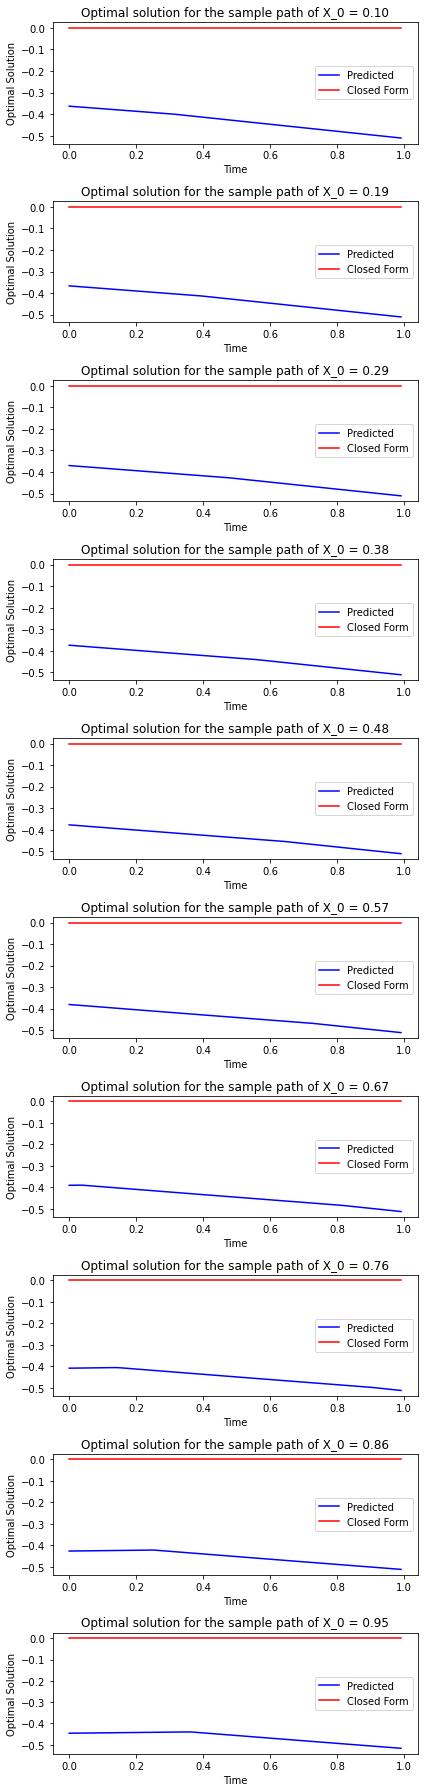

In [36]:
u_del=np.delete(u, -1, axis=1) # Just dropping the last time step as there is no control in final time
print(u_del.shape)
fig, axs = plt.subplots(M2,1, figsize=(6, 25))
t_eval=np.linspace(0,0.99,ite*ite)
print(t_eval)
# Plot x vs y and x vs z on each subplot
for i, ax in enumerate(axs):
    ax.plot(t_eval,pred[i,:], color='b', label='Predicted')
    ax.plot(t_eval,u_del[i,:], color='r', label='Closed Form')
    ax.set_xlabel('Time')
    ax.set_ylabel('Optimal Solution')
    ax.set_title(f'Optimal solution for the sample path of X_0 = {state_var[i,0]:.2f}')
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show() 

No handles with labels found to put in legend.


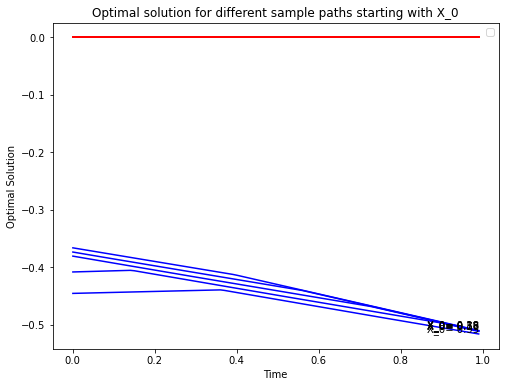

In [37]:
import matplotlib
# Set the backend for Qt5Agg
matplotlib.use('Qt5Agg')

x_0_values = state_var[:, 0]  # Assuming state_var[:, 0] holds your x_0 values for each i

# Increase the figure size
plt.figure(figsize=(8,6))

# Loop to plot each graph
for i in range(1, M2, 2):
    plt.plot(t_eval, pred[i, :], color='b', label='Predicted' if i == 0 else "")  # Show label only once
    plt.plot(t_eval, u_del[i, :], color='r', label='Closed Form' if i == 0 else "") # Show label only once
    
    # Add x_0 value near each line
    plt.text(t_eval[-1], pred[i, -1], f'X_0= {x_0_values[i]:.2f}', color='black', fontsize=10, 
             ha='right', va='bottom')  # Label for predicted solution
#     plt.text(t_eval[-1], u_del[i, -1], f'x_0 = {x_0_values[i]:.2f}', color='red', fontsize=10, 
#              ha='left', va='center')  # Label for true solution
    
    plt.xlabel('Time')
    plt.ylabel('Optimal Solution')
    plt.title('Optimal solution for different sample paths starting with X_0')

    # Display legend only once
plt.legend()

# Show the plot
plt.show()